In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

### Scikit-learnによる分類
* 実際のデータで，説明変数が多次元の場合の機械学習モデルを構築

説明変数として考えられるもの
* goal : 目標金額
* deadline :　納期
* launched : 開始日
* country : プロジェクト開催国
* currency : 通貨の単位
* deadline_days : 納期への近さ
* goal_per_days : 1日あたりの目標金額
* category_xxx : プロジェクトの小分類がxxxかどうか
* name_length : プロジェクト名の長さ
* name_xxx : プロジェクトのタイトルにxxxが含まれているか

In [2]:
#CSVファイル読み込み
df = pd.read_csv("../1_data/ks-projects-201801.csv")
df.index.name="id"

In [3]:
#欠損値がある列を確認
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [4]:
#欠測値がある列を落とす
#stateが「live」のデータを落としていることを明示するためにあえて記載
df = df[df['state'] != 'live']
df = df[~df['name'].isnull()]
df = df[~df['usd pledged'].isnull()]

In [5]:
df['state'].loc[df['state'] == 'successful'] = 1
df['state'].loc[df['state'] != 1] = 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#nameの長さを取得
df['name_length'] = df['name'].apply(lambda x: len(str(x).replace(' ', ''))).fillna(0)

In [7]:
#deadline,launchedを日付に変換するための関数
def period_to_date(x_date, format_date):
    x_date_format = datetime.datetime.strptime(x_date, format_date)
    return x_date_format

In [8]:
#deadline と　launched からプロジェクト納期への近さ(日数)を計算
df['deadline_period'] = df['deadline'].apply(lambda x : period_to_date(x, '%Y-%m-%d')) \
- df['launched'].apply(lambda x : period_to_date(x, '%Y-%m-%d %H:%M:%S'))
df['deadline_days'] = df['deadline_period'].apply(lambda x : x.days)

#goal に対して納期への日数1日あたりいくら必要かを計算
df['goal_per_days'] = df['goal'] / df['deadline_days']
df['goal_per_days'] = df['goal_per_days'].fillna(0)
df['goal_per_days'] [df['goal_per_days'] == np.inf]= 0

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
#pairplot用の変数を揃える
#ここでは更に、goal_per_days(1日あたりの目標金額),name_length(PJ名の長さ),deadline_days(納期に対してどのくらいの近さでリリースしたか)を指標として加える

df['goal_log'] = df['goal'].apply(lambda x: np.log(x+1))
df['goal_per_days_log'] = df['goal_per_days'].apply(lambda x: np.log(x+1))
df['deadline_days_log'] = df['deadline_days'].apply(lambda x: np.log(x+1))
df['name_length_log'] = df['name_length'].apply(lambda x: np.log(x+1))

In [10]:
#文字列を含む候補のリスト
name_first=['1st','First','FIRST','first','1ST']

#nameに特定の単語を含むか調べた列を追加
df['name_first'] = df['name'].str.contains('|'.join(name_first),na=False)

df['name_first'].loc[df['name_first'] == True] = 1
df['name_first'].loc[df['name_first'] == False] = 0

In [11]:
df[df['name_first'] != 0].to_csv('../1_data/name_first.csv')

In [12]:
#文字列を含む候補のリスト
name_quick=['quick','Quick','QUICK']

#nameに特定の単語を含むか調べた列を追加
df['name_quick'] = df['name'].str.contains('|'.join(name_quick),na=False)

df['name_quick'].loc[df['name_quick'] == True] = 1
df['name_quick'].loc[df['name_quick'] == False] = 0

In [13]:
#実データを見る
df[df['name_quick'] != 0]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,name_length,deadline_period,deadline_days,goal_per_days,goal_log,goal_per_days_log,deadline_days_log,name_length_log,name_first,name_quick
id,,,,,,,,,,,,,,,,,,,,,
227,1000992739,Quick Query - Relaunch!,Playing Cards,Games,USD,2014-08-18,750.0,2014-07-19 19:02:26,1207.00,1,...,20,29 days 04:57:34,29,25.862069,6.621406,3.290715,3.401197,3.044522,0,1
228,1000997384,"Quick, The Clockwork Knight Volume #2",Comics,Comics,USD,2014-06-03,2000.0,2014-04-16 05:25:22,2585.00,1,...,32,47 days 18:34:38,47,42.553191,7.601402,3.773983,3.871201,3.496508,0,1
487,1002344676,NO! - A game of quick moves and stolen turns,Tabletop Games,Games,CAD,2015-05-27,10000.0,2015-04-27 19:00:30,3969.00,0,...,35,29 days 04:59:30,29,344.827586,9.210440,5.845940,3.401197,3.583519,0,1
1275,1006492574,"TheXLC Pre-Printed MDF Wargame Terrain. Quick,...",Tabletop Games,Games,GBP,2014-11-22,2500.0,2014-11-01 10:46:09,7553.00,1,...,52,20 days 13:13:51,20,125.000000,7.824446,4.836282,3.044522,3.970292,0,1
2531,1013031233,The QuickSnap Replaceable Cat Scratcher - Feli...,Product Design,Design,USD,2016-08-23,10000.0,2016-07-19 18:51:14,22167.00,1,...,53,34 days 05:08:46,34,294.117647,9.210440,5.687374,3.555348,3.988984,0,1
2580,1013291461,nmbr – Keype it Quick,Gadgets,Technology,USD,2017-09-01,4500.0,2017-08-02 18:44:41,444.00,0,...,17,29 days 05:15:19,29,155.172414,8.412055,5.050961,3.401197,2.890372,0,1
3689,1019043800,Quick Quests: TCG,Tabletop Games,Games,USD,2016-09-01,2500.0,2016-08-03 18:47:14,32.00,0,...,15,28 days 05:12:46,28,89.285714,7.824446,4.502979,3.367296,2.772589,0,1
4741,1024121043,Steam Vegetables fast and quickly with a Micro...,Food,Food,USD,2014-12-21,15000.0,2014-11-21 08:49:57,0.00,0,...,47,29 days 15:10:03,29,517.241379,9.615872,6.250441,3.401197,3.871201,0,1
4922,1025125197,The MAXIS 360 - Quickest & Easiest Camera Moun...,Product Design,Design,USD,2012-06-24,45000.0,2012-05-27 06:12:42,9780.00,0,...,47,27 days 17:47:18,27,1666.666667,10.714440,7.419181,3.332205,3.871201,0,1


In [14]:
#文字列を含む候補のリスト
name_theatre=['theatre','Theatre','THERTRE','theater','Theater','THERTER']

#nameに特定の単語を含むか調べた列を追加
df['name_theatre'] = df['name'].str.contains('|'.join(name_theatre),na=False)

df['name_theatre'].loc[df['name_theatre'] == True] = 1
df['name_theatre'].loc[df['name_theatre'] == False] = 0

In [15]:
#文字列を含む候補のリスト
name_movie=['movie','Movie','movie']

#nameに特定の単語を含むか調べた列を追加
df['name_movie'] = df['name'].str.contains('|'.join(name_movie),na=False)

df['name_movie'].loc[df['name_movie'] == True] = 1
df['name_movie'].loc[df['name_movie'] == False] = 0

In [16]:
#category,main_category,currencyの値をダミー変数化
df = pd.get_dummies(df, columns = ['category','country','currency'])

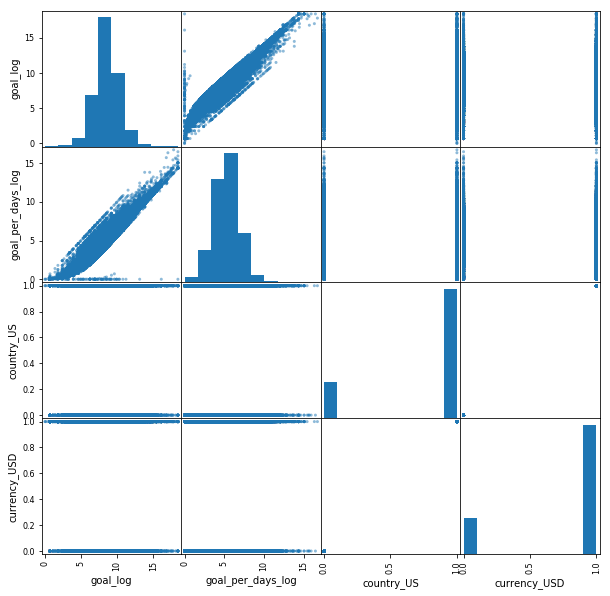

In [17]:
#説明変数の組み合わせに関していくつか相関係数を確認
pd.plotting.scatter_matrix(df[["goal_log", "goal_per_days_log", "country_US", "currency_USD"]], figsize=(10,10))
plt.show()

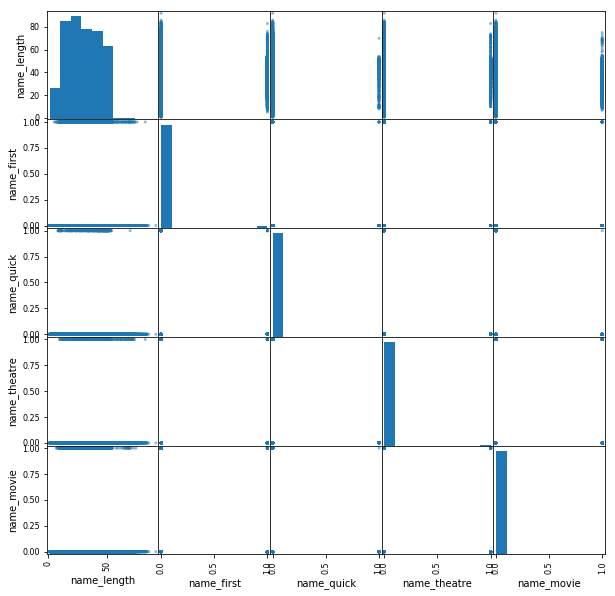

In [18]:
#説明変数の組み合わせに関していくつか相関係数を確認
pd.plotting.scatter_matrix(df[["name_length", "name_first", "name_quick", "name_theatre","name_movie"]], figsize=(10,10))
plt.show()

In [19]:
# 説明変数の相関係数を確認
df[["goal_log", "deadline_days_log","goal_per_days_log", "category_Chiptune","category_Anthologies", "country_US", "currency_USD","name_theatre","name_quick","name_length_log"]].corr()

,goal_log,deadline_days_log,goal_per_days_log,category_Chiptune,category_Anthologies,country_US,currency_USD,name_theatre,name_quick,name_length_log
goal_log,1.000000,0.228261,0.968793,-0.005421,-0.010989,-0.005975,-0.005975,-0.011709,0.006831,0.039412
deadline_days_log,0.228261,1.000000,0.001118,0.000910,-0.004892,0.025617,0.025617,0.004010,-0.000961,0.017194
goal_per_days_log,0.968793,0.001118,1.000000,-0.005759,-0.010313,-0.014214,-0.014214,-0.013536,0.007269,0.035383
category_Chiptune,-0.005421,0.000910,-0.005759,1.000000,-0.000443,-0.002928,-0.002928,-0.000690,-0.000273,0.006860
category_Anthologies,-0.010989,-0.004892,-0.010313,-0.000443,1.000000,-0.005553,-0.005553,-0.000755,-0.001285,0.007181
country_US,-0.005975,0.025617,-0.014214,-0.002928,-0.005553,1.000000,1.000000,0.006276,0.000034,0.025271
currency_USD,-0.005975,0.025617,-0.014214,-0.002928,-0.005553,1.000000,1.000000,0.006276,0.000034,0.025271
name_theatre,-0.011709,0.004010,-0.013536,-0.000690,-0.000755,0.006276,0.006276,1.000000,-0.002002,0.045356
name_quick,0.006831,-0.000961,0.007269,-0.000273,-0.001285,0.000034,0.000034,-0.002002,1.000000,0.012350
name_length_log,0.039412,0.017194,0.035383,0.006860,0.007181,0.025271,0.025271,0.045356,0.012350,1.000000


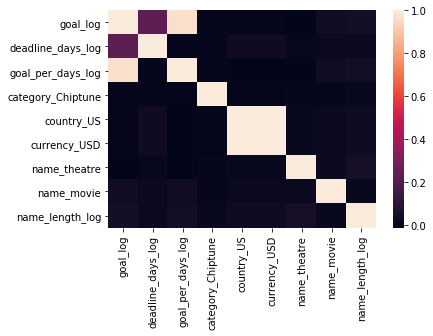

In [20]:
# 相関係数をヒートマップにして可視化
import seaborn as sns
sns.heatmap(df[["goal_log", "deadline_days_log","goal_per_days_log", "category_Chiptune", "country_US", "currency_USD","name_theatre","name_movie","name_length_log"]].corr())
plt.show()

goalとgoal_per_daysに強い正の相関、どちらか一方のみを使うことが推奨される。<br>
country_USとcurrency_USDはほぼ同じ特徴量を持った列であり、どちらか一方でよい。<br>
その他はどの説明変数に関してもほぼ相関がない、つまりここで出た7つのうちいずれか5つの説明変数に関しては独立して扱える。<br>

In [21]:
#goal_per_daysの値を標準化
df["goal_per_days_standardized"] = (df["goal_per_days"] - df["goal_per_days"].mean()) / df["goal_per_days"].std(ddof=0)

In [22]:
#deadline_daysの値を標準化
df["deadline_days_standardized"] = (df["deadline_days"] - df["deadline_days"].mean()) / df["deadline_days"].std(ddof=0)

In [23]:
#name_lengthの値を正規化
df["name_length_normalized"] = (df["name_length"] - df["name_length"].min()) / (df["name_length"].max() - df["name_length"].min())

In [24]:
#分類に使う説明変数を決定する
y = df["state"].values
X = df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].values

In [25]:
#テストデータの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)

clf.fit(X_train, y_train)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
w7 = clf.coef_[0, 6]
w8 = clf.coef_[0, 7]
w9 = clf.coef_[0, 8]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}".format(w0, w1, w2, w3, w4, w5, w6, w7, w8))

w0 = -1.678, w1 = -26.921, w2 = -1.436, w3 = 0.904, w4 = 1.219, w5 = 1.830, w6 = 0.044, w7 = 0.784, w8 = 0.312


In [27]:
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

# ラベルを予測
y_est = clf.predict(X_test)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))


# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est)

# カテゴリ「state」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -12.204
正答率 = 64.666%
適合率（Precision） = 64.946%
再現率（Recall） = 97.183%
F1値（F1-score） = 77.859%


In [28]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

,予測 = fail,予測 = successful
正解 = fail,46231,1340
正解 = successful,24953,1889


In [29]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

#ハイパーパラメータ調整
clf_rf = RandomForestClassifier(n_estimators=10,
                             max_depth=9,
                             criterion="gini",
                             min_samples_leaf=2, 
                             min_samples_split=2,
                             random_state=1234)

clf_rf.fit(X_train, y_train)

#テストデータに対する予測データ作成
y_predict = clf_rf.predict(X_test)

In [30]:
#正解率
print(accuracy_score(y_test, y_predict))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_predict)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_predict)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6622767527179391
対数尤度 = -11.665
正答率 = 66.228%


,予測 = fail,予測 = successful
正解 = fail,43285,4286
正解 = successful,20845,5997


1   goal_per_days_standardized   0.5310408957749883
2   deadline_days_standardized   0.344648550843928
3   name_length_normalized   0.06096291320375916
4   currency_USD   0.04120543998657676
5   name_theatre   0.009732239851303342
6   category_Anthologies   0.006427014729204613
7   name_first   0.0035702486700230967
8   name_movie   0.001567111543991652
9   category_Chiptune   0.0005419647519927065
10   name_quick   0.00030362064423220995


/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


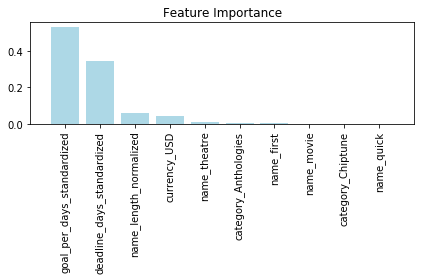

In [31]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
#特徴量の重要度
feature = clf_rf.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.ix[:, 'number']

#特徴量の名前
label = df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print (str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

goal_per_days,deadline_daysが重要だと評価されている

In [32]:
#アダブースト
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf_ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                                min_samples_leaf=2,
                                                min_samples_split=2, 
                                                random_state=1234,
                                                criterion="gini"))
clf_ad.fit(X_train, y_train)

#テストデータに対する予測データ作成
y_predict = clf_ad.predict(X_test)

In [33]:
#正解率
print(accuracy_score(y_test, y_predict))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_predict)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_predict)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_predict), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6660395361025627
対数尤度 = -11.535
正答率 = 66.604%


,予測 = fail,予測 = successful
正解 = fail,41485,6086
正解 = successful,18765,8077


[0.44031259 0.30823588 0.17332659 0.00511027 0.00310614 0.00243716
 0.00507648 0.04233608 0.00386707 0.01619175]


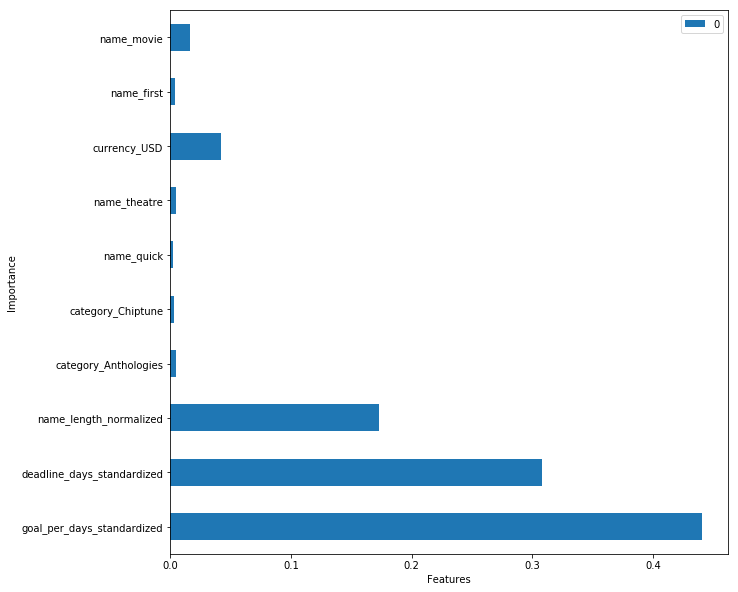

In [34]:
print(clf_ad.feature_importances_)

feature_name=df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]
feature_name

# 説明変数の重要度を棒グラフに出力する。
pd.DataFrame(clf_ad.feature_importances_, feature_name).plot.barh(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [35]:
#XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# xgboostモデルの作成
clf_xgb = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_xgn = GridSearchCV(clf_xgb, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
clf_xgn.fit(X_train, y_train)
print (clf_xgn.best_params_, clf_xgn.best_score_)

# 改めて最適パラメータで学習
clf_xgb = xgb.XGBClassifier(**clf_xgn.best_params_)
clf_xgb.fit(X_train, y_train)

# 学習モデルの保存、読み込み
import pickle
pickle.dump(clf_xgb, open("model_xgb.pkl", "wb"))
clf_xgb = pickle.load(open("model_xgb.pkl", "rb"))

# 学習モデルの評価
pred = clf_xgb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

/home/takuya-06261_semantic/anaconda3/envs/my_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.0min finished


{'max_depth': 4, 'n_estimators': 200} 0.6689154003541083
[[41556  6015]
 [18794  8048]]
              precision    recall  f1-score   support

           0       0.69      0.87      0.77     47571
           1       0.57      0.30      0.39     26842

   micro avg       0.67      0.67      0.67     74413
   macro avg       0.63      0.59      0.58     74413
weighted avg       0.65      0.67      0.63     74413



In [39]:
#正解率
print(accuracy_score(y_test, pred))

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, pred)))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y_test, pred), 
                        index=['正解 = fail', '正解 = successful'], 
                        columns=['予測 = fail', '予測 = successful'])
conf_mat

0.6666039536102563
対数尤度 = -11.515
正答率 = 66.660%


,予測 = fail,予測 = successful
正解 = fail,41556,6015
正解 = successful,18794,8048


[0.284104   0.22521482 0.055777   0.09184134 0.01270799 0.00988532
 0.09298378 0.17264973 0.039969   0.01486703]


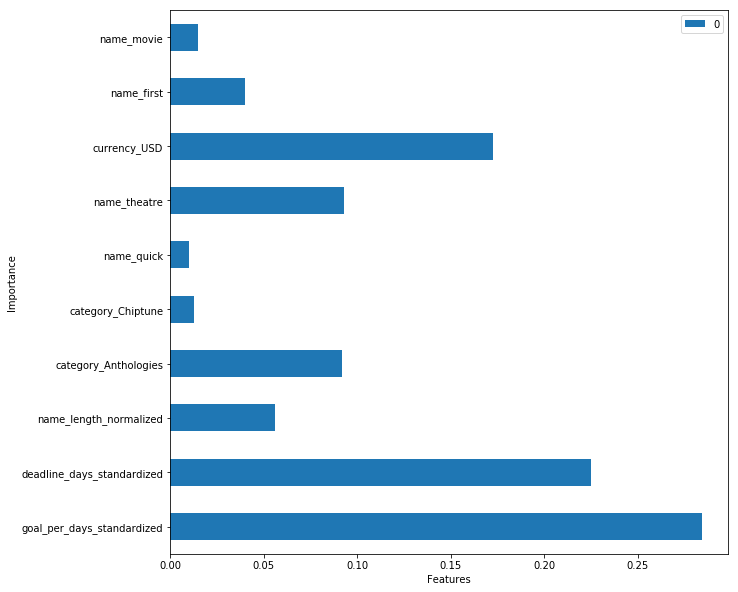

In [37]:
print(clf_xgb.feature_importances_)

feature_name=df[["goal_per_days_standardized","deadline_days_standardized","name_length_normalized","category_Anthologies","category_Chiptune","name_quick","name_theatre","currency_USD","name_first","name_movie"]].columns[0:]
feature_name

# 説明変数の重要度を棒グラフに出力する。
pd.DataFrame(clf_xgb.feature_importances_, feature_name).plot.barh(figsize=(10,10))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

10個の説明変数でも、アルゴリズムによって有効利用する説明変数が変わってくる。<br>
人手の感覚で説明変数を決め打ちせず、多数の候補を残してRFE等で説明変数を決定するのも手だと考えられた。